We would like to explore Random Forest Regressors and Support Vector Machines along with some input variables to see if we can make a model that accurately forecasts energy demand. We aim to achieve better results than simply saying 'The demand in 30 minutes time will be the same as it is right now'. This is calculated below as having a mean average loss of 218.

In [1]:
# Import libraries
from warnings import filterwarnings
import os, sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
import math
from pprint import pprint
from datetime import datetime, timedelta
from sklearn.svm import SVR
from matplotlib import pyplot as plt
import forestci as fci
from sklearn.feature_selection import mutual_info_regression  
from sklearn.feature_selection import SelectKBest

# Suppress annoying deprecation warnings
filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')

# read data
data = pd.read_csv('F:/Users/Dave/Desktop/UNSW-Capstone-Group-E/src/chrisdavid/Cleaned_Data_mkII.csv')
#data = pd.read_csv('./Cleaned_Data_mkII.csv')

# Set random state
STATE = 2

# Makes sure datetime is in datetime format
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# We want to test a time column as an input
data['time'] = (data['DATETIME'].dt.strftime("%H%M%S"))

# Also would like to test demand and tmeperature 30 and 60 mins before the current time as input
data['demand_30'] = data.TOTALDEMAND.shift(1)
data['demand_60'] = data.TOTALDEMAND.shift(2)

data['temp_30'] = data.TEMPERATURE.shift(1)
data['temp_60'] = data.TEMPERATURE.shift(2)

# Select data from the past 5 years
mask = (data['DATETIME'] >= '2016-01-01') & (data['DATETIME'] < '2021-01-01')
data = data.loc[mask]

# And an indictor if it is a weekend or not
data['is_weekday'] = data['DATETIME'].dt.weekday
data['is_weekday'] = np.where(data['is_weekday'] < 5, 1, 0)

# import weather data
weather = pd.read_csv('F:/Users/Dave/Desktop/UNSW-Capstone-Group-E/src/chrisdavid/weather.csv')

# Convert datetime to date
weather['date'] = pd.to_datetime(weather[['Year','Month','Day']]).dt.date

# Extract just day and rain columns
weather.columns = ['drop1','drop2','drop3','drop4','drop5','rain','drop6','drop7','date']
weather = weather[['date','rain']]

# Fill NA values
weather['rain'].fillna(method = 'ffill', inplace = True)

# Create day column in data and merge using it
data['date'] = data['DATETIME'].dt.date

# Merge existing data with the weather data
data = data.merge(weather, on = 'date')

# Create day and month columns
data['day'] = data['DATETIME'].dt.day
data['month'] = data['DATETIME'].dt.month

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
Failed to import duecredit due to No module named 'duecredit'


After creating a data frame with all of the features that we deem potentially interesting, we would like to evaluate their suitability for use in a random forest regressor. To do feature selection we will use mutual information (information gain of each input in relation to the output variable) as a selection metric.

In [2]:
# Suppress annoying deprecation warnings
filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')

# Split into input and output dataframes
Y = data['TOTALDEMAND']
X = data.drop(columns = ['TEMPERATURE', 'TOTALDEMAND', 'DATETIME', 'date'])

# Find the highest mutual information
selector = SelectKBest(mutual_info_regression, k = 'all')
X_train_new = selector.fit_transform(X, Y)  
mask = selector.get_support()

# Create a mask
new_features = X.columns[mask]

# Print features and their dependencies
for i in range(len(new_features)):
    print('Score: ', selector.scores_[i], 'Feature: ', new_features[i])

Score:  0.39929557262306314 Feature:  time
Score:  1.8495296139521882 Feature:  demand_30
Score:  1.234411385940378 Feature:  demand_60
Score:  0.16443847410683343 Feature:  temp_30
Score:  0.1614742823178057 Feature:  temp_60
Score:  0.0362467251250691 Feature:  is_weekday
Score:  0.02948672345017389 Feature:  rain
Score:  0.003169378751444185 Feature:  day
Score:  0.12152920896414265 Feature:  month


From this, we can see that time, demand_30, demand_60, temp_30, temp_60, and month are all potentially useful in a model. temp_30 and temp_60 likely to be highly correlated and not useful to include both.

In [3]:
# Create features and target sets
features = data[['time', 'demand_30', 'demand_60', 'temp_30']]
target = data['TOTALDEMAND']

# Convert to numpy arrays and split training/test data
features_np = pd.DataFrame(features).to_numpy()
target_np = np.ravel(pd.DataFrame(target).to_numpy())

features_train, features_test, target_train, target_test = train_test_split(features_np,
                                                                            target_np, random_state = STATE)

# Implement Random Forest
rnd_clf = RandomForestRegressor(random_state = STATE, criterion = 'absolute_error')
rnd_clf.fit(features_train, target_train)

# Print error
rf_predicted = rnd_clf.predict(features_test)
rf_MAE = mean_absolute_error(target_test, rf_predicted)
print("Baseline Random Forest MAE: ", rf_MAE)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rnd_clf.get_params())

Baseline Random Forest MAE:  56.29793165480754
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}


We have managed to eliminate most of the remaining inputs. We have; time, demand_30, demand_60 and temp_30 as useful to our model.

Let's try random search of optimizing hyperparamters as a quick way to tell if our baseline model can perform any better.

In [4]:
## Tune hyperparameters
# Create the grid
random_grid = {'n_estimators': list(range(80, 140, 20)),
               'criterion': ['mae'],
               'max_features': ['auto'],
               'max_depth': list(range(10, 20, 5)),
               'min_samples_split': list(range(2, 8, 2)),
               'min_samples_leaf': list(range(1, 10, 2)),
               'bootstrap': [True]}

# Randomly saearch the grid for the best performance
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid, 
                               n_iter = 3, cv = 3, verbose = 2, random_state = STATE, n_jobs = -1)

rf_random.fit(features_train, target_train)

# Print error
rf_random_pred = rf_random.best_estimator_.predict(features_test)
rf_random_MAE = mean_absolute_error(target_test, rf_random_pred)
print("Baseline Random Forest MAE: ", rf_random_MAE)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_random.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Baseline Random Forest MAE:  56.55772278952289
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mae',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 80}


This tuning is only a little better than our base model. No point in continuing hyperparpmeter tuning further, or in continuing with the model, unless we can think of other inputs. We will print some graphs to visualize model performances.

In [5]:
err_down = []
err_up = []

for x in range(len(features_test)):
    preds = []
    for pred in rf_random.best_estimator_.estimators_:
        preds.append(pred.predict(features_test)[x])
    err_down.append(np.percentile(preds, 10 / 2))
    err_up.append(np.percentile(preds, 90 / 2))

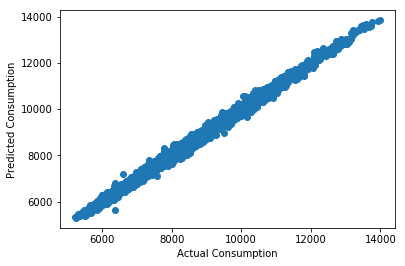

In [6]:
# Plot predicted vs actual without error bars
plt.scatter(target_test, rf_predicted)
plt.plot()
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.show()

In [16]:
df = pd.DataFrame(list(zip(target_test, err_down, err_up)), columns = ['Actual_Values', 'Lower_5%', 'Upper_5%'])
df.to_csv(r'.\conf_int_random_forest.csv', index = False)

We will now start with SVM modelling

In [7]:
# Implement baseline Support Vector Machine Regressor
regressor = SVR(kernel = 'rbf')
regressor.fit(features_train, target_train)

# Print error
svm_predicted = regressor.predict(features_test)
svm_MAE = mean_absolute_error(target_test, svm_predicted)
print("SVM MAE: ", svm_MAE)

# Look at parameters used
print('Parameters currently in use:\n')
pprint(regressor.get_params())

SVM MAE:  800.9120750034796
Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [8]:
## Tune hyperparameters
# Create the grid
SVM_param_grid = {'C' : [0.1, 1, 10],
                 'gamma' : [1, 0.1, 0.01],
                 'kernel' : ['rbf']}

# Make sure the model uses MAE as a score function
scorer = make_scorer(mean_absolute_error, greater_is_better = False)

# Randomly saearch the grid for the best performance
svr_gs = GridSearchCV(SVR(), SVM_param_grid, scoring=scorer)
svr_gs.fit(features_train, target_train)

# Create predicted values
grid_preds = svr_gs.predict(features_test)

best_SVM_grid_error = mean_absolute_error(target_test, grid_preds)

# Print error
print("SVM Grid Search Tuning Error: ", best_SVM_grid_error)

# Look at parameters used
print('Parameters currently in use:\n')
pprint(svr_gs.get_params())


SVM Grid Search Tuning Error:  980.0663327240306
Parameters currently in use:

{'cv': None,
 'error_score': nan,
 'estimator': SVR(),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'n_jobs': None,
 'param_grid': {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': make_scorer(mean_absolute_error, greater_is_better=False),
 'verbose': 0}


In [11]:

predictions = list(rf_random.predict(features_np))
targets = list(target_np)
output = pd.DataFrame({'prediction':predictions,'target':targets})
output.to_csv('output_rf.csv')

In [12]:
output

,prediction,target
0,7116.206875,7139.95
1,6969.004687,6976.20
2,6781.128313,6751.26
3,6464.565125,6421.49
4,6205.307375,6125.98
...,...,...
87691,6991.332812,7072.75
87692,7086.566625,7062.97
87693,7097.202562,7172.60
87694,7150.079625,7125.65
